### This script will load some real trajectory data and fit different projectile modles to it
First import the maths and plotting packages we used before

In [1]:
import numpy as np
from matplotlib import pyplot as plt

#### We need to load some trajectory data
These are real trajectories from a table tennis ball.

There are three columns; [x, y, velocity].

For now, we're going to load trajectory 75 and separate out the parameters (note different notations)

In [2]:
trajectory=75
data = np.genfromtxt('trajectories/trajectory'+str(trajectory)+'.txt',delimiter=',');
sx = data[:,0];
sy = data[:,1];
vx = data[:,2];
vy = data[:,3];

#### Let's plot the trajectory
Each one starts at zero on the x-axis and ends when the y value reaches zero (when the ball hit the table). The launch height and angle are variable

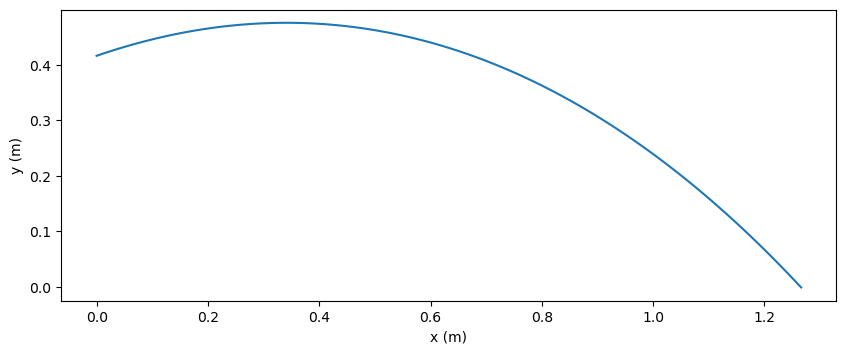

In [3]:
...
...
...
...

#### We also have the velocities already calculated. Let's plot these
We'll first need to define a time variable. We know the sampling rate was 250Hz

In [4]:
sampleRate=250
t=np.arange(0, len(sx)/sampleRate,1/sampleRate)

#### Now plot the horizontal and vertical velocity
As you can see the horizontal velocity isn't constant. What causes this and what effect will it have?

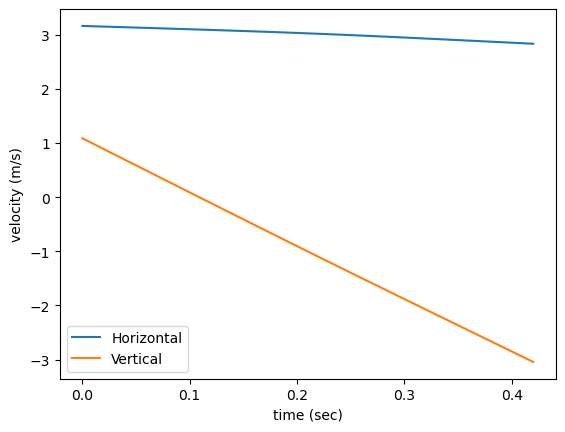

In [5]:
...
...
...
...

#### We now need to define the starting parameters for the model to work

In [6]:
v0vert=vy[0]
v0horz=vx[0]
h0=sy[0]
theta0=np.degrees(np.arctan(vy[0]/vx[0]))

#### We're now going to define a custom function called 'model_trajectory' that will do all the calculations in one go.
Once its been defined, a function can then be called anytime in the script. You've already used several built in ones such as 'np.degrees' and 'np.arange'

In [7]:
def model_trajectory(v0vert,v0horz,h0,theta0,t):
        
    svert = h0 + v0vert*t-0.5*9.81*np.square(t)
    shorz = v0horz*t

    return svert,shorz

#### We can now call this function and model the trajectory based on the starting parameters

In [8]:
svert,shorz=model_trajectory(v0vert,v0horz,h0,theta0,t)

#### Let's see how they compare

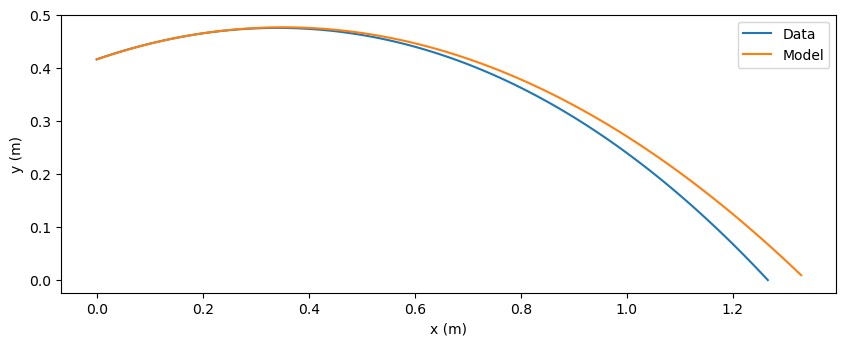

In [9]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(sx,sy,label='Data');
ax.plot(shorz,svert,label='Model');
ax.axis('scaled')
ax.set_xlabel('x (m)');
ax.set_ylabel('y (m)');
ax.legend();

#### It's not terrible but the model overpredicts the range
What if we take into account air resistance using the new function below? This gets a bit more complicated because now the velocity changes constantly through time so we have to keep updating it using a for loop.

We'll also make this model do all the initial formatting of the data so it can be quickly run on other datasets

In [10]:
def model_trajectory_air_resistance(CD0,data,sampleRate,S,m,plot):

    # format data
    sx = data[:,0];
    sy = data[:,1];
    vx = data[:,2];
    vy = data[:,3];
    
    v0vert=vy[0]
    v0horz=vx[0]
    h0=sy[0]
    theta0=np.degrees(np.arctan(vy[0]/vx[0]))
    
    # get time series
    t=np.arange(0, len(sx)/sampleRate,1/sampleRate)

    # fixed parameters
    rho = 1.225; # air density
    g = 9.81 # acceleration due to gravity
    
    vy = v0vert
    vx = v0horz
    theta = theta0
    
    shorz=np.array([0])
    svert=np.array([h0])
        
    t_step = 1/sampleRate # time step
    
    cont=1
    
    while cont==1:
        
        vtot=np.hypot(vx,vy) # total velocity

        ax=-0.5*1/m*rho*vtot*S*(vx*CD0); # horizontal acceleration
        ay=-0.5*1/m*rho*vtot*S*(vy*CD0)-g; # vertical acceleration
    
        # update variables
        vx=vx + ax*t_step; # horizontal velocity
        vy=vy + ay*t_step; # vertical velocity
        
        shorznew=shorz[-1] + vx*t_step + 0.5*ax*np.square(t_step);
        svertnew=svert[-1] + vy*t_step + 0.5*ay*np.square(t_step);
        
        if len(shorz)>=len(sx):
            cont=0
        else:
            shorz = np.append(shorz,shorznew)
            svert = np.append(svert,svertnew)
     
    if plot==1:
        fig, ax = plt.subplots(figsize=(5,5))
        ax.plot(sx,sy,label='Data');
        ax.plot(shorz,svert,label='Model');
        ax.axis('scaled')
        ax.set_xlabel('x (m)');
        ax.set_ylabel('y (m)');
        ax.legend();
        

    return svert,shorz

#### We have a few new parameters to define
S = projected surface area of the ball (m)

m = mass of the ball (kg)

CD0 = drag coefficient

In [11]:
S = 0.00125 # fixed, based on a standard 40mm diameter ball
m = 0.0027 # fixed, based on a standard 2.7g ball
CD0 = 0.4 # from literature, but only an estimate so could be varied

#### Run the function and see if it improves things
Try modifying CD0 and see if that improves things

In [12]:
svert,shorz=model_trajectory_air_resistance(CD0,data,sampleRate,S,m,CD0)

#### Can we find an optimal value for CD0?
First need to calculate error sum of squares

In [13]:
error=np.sum(np.square(svert-sy)+np.square(shorz-sx))
print('model error sum of squares',error,'m^2')

model error sum of squares 0.03266037330505127 m^2


#### Try brute force search method

Optimal CD0 = 0.24


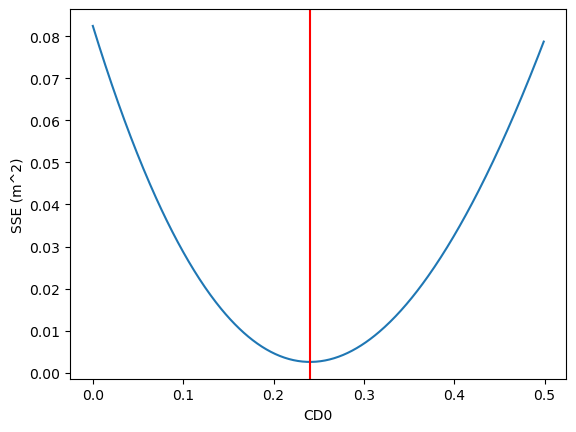

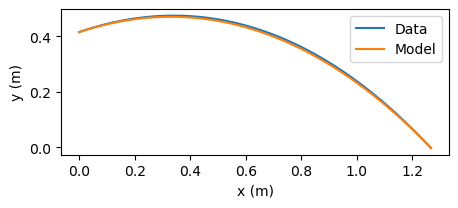

In [14]:
error=np.array([])

CD0range=np.arange(0,0.5,0.001)

for CD0temp in CD0range:
    svert,shorz=model_trajectory_air_resistance(CD0temp,data,sampleRate,S,m,0)
    
    error=np.append(error,np.sum(np.square(svert-sy)+np.square(shorz-sx)))
    
errormin_index = np.argmin(error)
CD0_opt=CD0range[errormin_index]

print('Optimal CD0 =',CD0_opt)

plt.plot(CD0range,error)
plt.axvline(CD0_opt,color = 'r')

plt.xlabel('CD0')
plt.ylabel('SSE (m^2)');

svert,shorz=model_trajectory_air_resistance(CD0_opt,data,sampleRate,S,m,1)

#### You can get a pretty good result with the right value of CD0
But what if we try a different sequence?

Let's load up a different dataset and run the function. You can go up trajectory 82

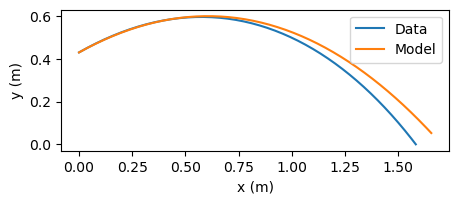

In [15]:
trajectory=58
CD0=0.217
data = np.genfromtxt('trajectories/trajectory'+str(trajectory)+'.txt',delimiter=',');
svert,shorz=model_trajectory_air_resistance(CD0,data,sampleRate,S,m,1)

#### Some are ok, but there are also a lot that haven't worked well. What are we missing?
Let's load up some data on the ball spin rates

#### We can plot a histogram of them and indicate the 75th trajectory
Topspin is negative, backspin is positive

The 75th sequence had almost no spin, which is why it worked quite well

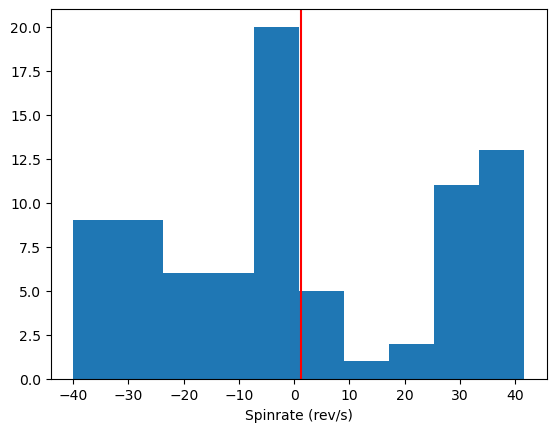

In [16]:
spinrates = np.genfromtxt('spinrates.txt',delimiter=',');
fig, ax=plt.subplots(1)
ax.hist(spinrates)
ax.axvline(spinrates[74],color = 'r') # zero-based indexing so have to use -1
ax.plot()
ax.set(xlabel='Spinrate (rev/s)');

#### So we can make a final model that incorporates spin.
This will affect both lift and drag

In [17]:
def model_trajectory_full_model(CD0,CLa,data,sampleRate,S,m,omega,plot):

    # format data
    sx = data[:,0];
    sy = data[:,1];
    vx = data[:,2];
    vy = data[:,3];
    
    v0vert=vy[0]
    v0horz=vx[0]
    h0=sy[0]
    theta0=np.degrees(np.arctan(vy[0]/vx[0]))
    
    # get time series
    t=np.arange(0, len(sx)/sampleRate,1/sampleRate)

    # fixed parameters
    rho = 1.225; # air density
    g = 9.81 # acceleration due to gravity
    
    vy = v0vert
    vx = v0horz
    theta = theta0
    
    shorz=np.array([0])
    svert=np.array([h0])
        
    t_step = 1/sampleRate # time step
    
    # lift and drag coefficients taking into account spin
    CL=(-CLa*np.exp(-0.25*np.absolute(omega))+CLa)*np.sign(omega);
    CD=CD0+0.005*np.absolute(omega);

    cont=1
    
    while cont==1:
        
        vtot=np.hypot(vx,vy) # total velocity

        ax=-0.5*1/m*rho*vtot*S*(vx*CD+vy*CL); # horizontal acceleration
        ay=-0.5*1/m*rho*vtot*S*(vy*CD-vx*CL)-g; # vertical acceleration
    
        # update variables
        vx=vx + ax*t_step; # horizontal velocity
        vy=vy + ay*t_step; # vertical velocity
        
        shorznew=shorz[-1] + vx*t_step + 0.5*ax*np.square(t_step);
        svertnew=svert[-1] + vy*t_step + 0.5*ay*np.square(t_step);
        
        if len(shorz)>=len(sx):
            cont=0
        else:
            shorz = np.append(shorz,shorznew)
            svert = np.append(svert,svertnew)
     
    if plot==1:
        fig, ax = plt.subplots(figsize=(10,5))
        ax.plot(sx,sy,label='Data');
        ax.plot(shorz,svert,label='Model');
        ax.axis('scaled')
        ax.set_xlabel('x (m)');
        ax.set_ylabel('y (m)');
        ax.legend();

    return svert,shorz

#### Let's try with some trajectories and run the final model
Try changing the values of CD0 and CLa to see their effect. Can you find a combination that seems optimal?

model error 0.1588813314843369 m


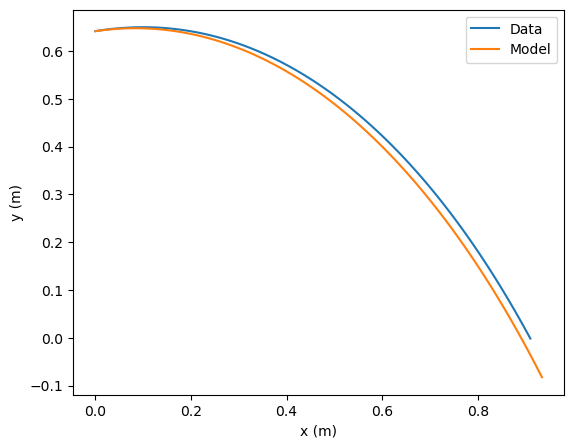

In [18]:
trajectory=50
data = np.genfromtxt('trajectories/trajectory'+str(trajectory)+'.txt',delimiter=',');
omega=spinrates[trajectory-1]

CD0=...
CLa=...

svert,shorz=model_trajectory_full_model(CD0,CLa,data,sampleRate,S,m,omega,1)

sx = data[:,0];
sy = data[:,1];
error=np.sum(np.square(svert-sy)+np.square(shorz-sx))
print('model error',error,'m')

#### Using brute force will be very slow (1000 x 1000 x 82 = 82 million iterations...)
So can instead look at  least squares solver